## First-order Markov Chain

To begin with, let's try to infer transition probabilities matrix from an observed sequence of states using a Dirichlet prior and custom likelihood. Sequence is a result of Markov Process with known transition matrix.


In [184]:
import pymc3 as pm
import numpy as np
from scipy import stats, optimize
import pandas as pd
import matplotlib.pyplot as plt
import theano.tensor as tt
import theano.tensor.slinalg as nla
import theano

#idealized transition matrix corresponding to coarsening-upwards lithology
TR = np.array([[0.1, 0.7, 0.1, 0.1],[0.1, 0.1, 0.7, 0.1],[0.1, 0.1, 0.1, 0.7],[0.7, 0.1, 0.1, 0.1]])
N_state = TR.shape[0]

print('Number of states: %s\n'%N_states)
print('Transition matrix: \n%s\n'%TR)

stationary_dist = lambda X : nla.solve((tt.eye(N_states)-X+tt.ones((N_states, N_states))).T, tt.ones(shape=N_states))

print('Stationary distribution: %s'%stationary_dist(TR).eval())

Number of states: 4

Transition matrix: 
[[0.1 0.7 0.1 0.1]
 [0.1 0.1 0.7 0.1]
 [0.1 0.1 0.1 0.7]
 [0.7 0.1 0.1 0.1]]

Stationary distribution: [0.25 0.25 0.25 0.25]


In [185]:
seq_len = 10000 #length of sequence to simulate
TR_c = TR.cumsum(axis=1)
seq = np.zeros((seq_len,), dtype=int)
for i in range(1,seq_len):
    seq[i] = np.sum(TR_c[seq[i-1]]<np.random.rand())
print('Observed sequence size: %s'%seq.shape)

Observed sequence size: 10000


#### Define PyMC model as follows:
$$P(z_t|z_{t-1}=s_i) = A_i, i=1...N $$
$$A_i \sim Dirichlet(a)$$
Then, probability of an observed sequence is defined as
$$P(\vec{z}|A)=\prod_{t=1}^{T} {P(z_t|z_{t-1};A)}=\prod_{t=1}^{T} {A_{ij}}$$
or, applying log-transformation:
$$logP(\vec{z}|A)=\sum_{t=1}^{T} {logP(z_t|z_{t-1};A)}=\sum_{t=1}^{T} {logA_{ij}}$$

In [189]:
N_states = TR.shape[0]
with pm.Model() as model:
    A = pm.Dirichlet('A', a=np.ones((N_states, N_states)), shape=(N_states,N_states))
    P0 = stationary_dist(A)
    out = pm.Potential('out', tt.log(P0[seq[0]]) + tt.sum(pm.Categorical.dist(A[seq[:-1]]).logp(seq[1:])))
    start = pm.find_MAP()
    trace = pm.sample(start=start) 

logp = -9,257.4, ||grad|| = 0.0028022: 100%|██████████| 12/12 [00:00<00:00, 293.74it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:56<00:00, 20.52draws/s] 


We can now compare the inferred transition matrix with the source one. Also, trace plots are useful to evaluate MCMC performance. Below are MCMC chain traces (left) and histogram of transition matrix posterior (right).

Source transition matrix: 
[[0.1 0.7 0.1 0.1]
 [0.1 0.1 0.7 0.1]
 [0.1 0.1 0.1 0.7]
 [0.7 0.1 0.1 0.1]]

Inferred transition matrix: 
[[0.08848451 0.69579115 0.11524299 0.10048135]
 [0.11630482 0.09509264 0.70287338 0.08572917]
 [0.09138006 0.10136643 0.09738376 0.70986976]
 [0.73059269 0.09933086 0.08855095 0.08152551]]

Stationary distribution: 
[0.25360826 0.25004959 0.2511497  0.24519246]

Trace plot:


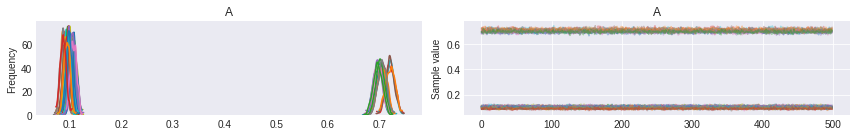

In [190]:
TR_post = np.array(trace['A'])
print('Source transition matrix: \n%s\n' %TR)
print('Inferred transition matrix: \n%s\n' %TR_post[-1])
print('Stationary distribution: \n%s\n' %stationary_dist(TR_post[-1]).eval())
print('Trace plot:')
pm.traceplot(trace);

Alternatively, instead of using DesnityDist with likelihood function, we can define a child class to PyMC Categorical and override methods as needed.

In [193]:
class MarkovChain(pm.Categorical):
    def __init__(self, p=None, *args, **kwargs):
        super().__init__(p, *args, **kwargs)
        self.p = p
        self.mode = tt.cast(0,dtype='int64')
        
    def logp(self, x):
        p0 = stationary_dist(self.p)
        return tt.log(p0[x[0]]) + tt.sum(pm.Categorical.dist(self.p[x[:-1]]).logp(x[1:]))
    
N_states = 4
with pm.Model() as model:
    A = pm.Dirichlet('A', a=np.ones((N_states, N_states)), shape=(N_states,N_states))
    out = MarkovChain('out', p=A, shape=seq.shape[0], observed=seq)
    star = pm.find_MAP()
    trace = pm.sample(start=start)
model

logp = -9,257.4, ||grad|| = 0.0028022: 100%|██████████| 12/12 [00:00<00:00, 268.59it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:43<00:00, 91.73draws/s] 


Inferred transition matrix: 
[[0.1 0.7 0.1 0.1]
 [0.1 0.1 0.7 0.1]
 [0.1 0.1 0.1 0.7]
 [0.7 0.1 0.1 0.1]]

Inferred transition matrix: 
[[0.09553583 0.69477693 0.11125371 0.09843353]
 [0.09854883 0.09921701 0.70517115 0.09706301]
 [0.10683325 0.10761007 0.09851236 0.68704432]
 [0.71714163 0.08996816 0.09983938 0.09305083]]

Stationary distribution: 
[0.25193046 0.24910832 0.25317221 0.24578901]

Trace plot:


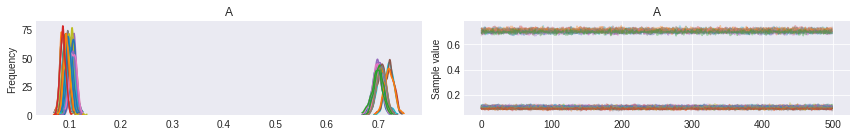

In [194]:
TR_post = np.array(trace['A'])
print('Inferred transition matrix: \n%s\n' %TR)
print('Inferred transition matrix: \n%s\n' %TR_post[-1])
print('Stationary distribution: \n%s\n' %stationary_dist(TR_post[-1]).eval())
print('Trace plot:')
pm.traceplot(trace);

## Hidden Markov Model



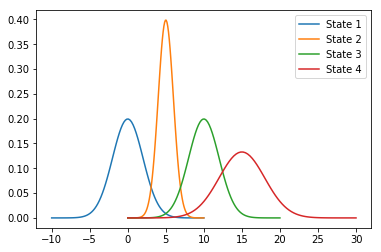

In [160]:
import scipy.stats as stats
x = np.linspace(-10, 10, 100)

ems_mu = np.array([0, 5, 10, 15]);
ems_sd = np.array([2, 1, 2, 3]);

for i in range(0,4):
    x = np.linspace(-5*ems_sd[i]+ems_mu[i], 5*ems_sd[i]+ems_mu[i], 100)
    plt.plot(x, stats.norm.pdf(x, ems_mu[i], ems_sd[i]), label='State %s'%(i+1))
plt.legend();

In [195]:
seq1 = seq[0:1000]
seq_ems = np.array(pm.Normal.dist(mu=ems_mu[seq1], sd=ems_sd[seq1]).random())

In [196]:
class HMMEmission(pm.Continuous):
    def __init__(self, mu=None, sd=None, states=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mu = tt.constant(mu)
        self.sd = tt.constant(sd)
        self.states = states
        self.mode = tt.cast(0,dtype='float64')

    def logp(self, x):
        return tt.sum(pm.Normal.dist(self.mu[states], self.sd[states]).logp(x))
    

with pm.Model() as model:
    A = pm.Dirichlet('A', a=np.ones((N_states, N_states)), shape=(N_states,N_states))
    states = MarkovChain('states', A, shape=seq_ems.shape[0], dtype = 'int64')
    ems = HMMEmission('ems', mu=ems_mu, sd=ems_sd, states=states, observed = seq_ems)
    #step1 = pm.Metropolis(vars=[A])
    #step2 = pm.CategoricalGibbsMetropolis(vars=[states])
    start = pm.find_MAP()
    trace = pm.sample(start=start)
model

logp = -13,090, ||grad|| = 0.00041: 100%|██████████| 26/26 [00:00<00:00, 636.48it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [A]
>CategoricalGibbsMetropolis: [states]
Sampling 4 chains: 100%|██████████| 4000/4000 [07:16<00:00,  3.05draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [79]:
A = trace['A'][-1]
s = trace['states']
print(seq)
print(s[-1])
np.linalg.norm(s[-3]-seq,2)

[0 0 1 0 1 2 0 1 2 3 1 2 0 1 2 3 0 1 0 1 2 3 0 1 2 3 0 1 1 2 1 3 0 0 1 2 3
 0 1 2 3 0 1 2 3 2 3 0 1 2 3 0 2 1 2 1 2 3 2 0 0 1 2 3 0 2 3 0 1 2 3 2 3 0
 1 2 3 0 1 3 3 1 3 0 0 3 0 1 1 3 0 1 2 3 0 0 2 1 2 0 0 2 1 2 3 0 1 2 2 3 0
 1 3 0 1 1 2 3 3 2 3 0 3 3 0 0 1 2 3 2 3 0 2 1 2 1 2 3 0 0 1 2 3 0 0 1 0 3
 3 3 0 3 3 0 1 2 3 3 3 0 1 2 3 1 0 1 2 3 1 2 1 2 3 1 2 3 0 0 2 3 0 1 2 3 3
 0 1 2 1 1 1 2 2 3 0 1 1 0 1 2 3 2 3 0 0 1 3 0 1 2 0 1 2 3 0 1 3 0 2 3 0 1
 2 3 2 3 0 1 2 3 2 1 2 3 1 1 2 3 0 1 1 0 1 2 3 0 0 1 2 0 1 1 2 3 1 2 3 0 1
 2 0 1 2 2 2 3 0 1 2 3 0 1 2 1 2 0 3 0 1 2 3 0 1 2 2 3 0 0 1 0 3 3 0 1 2 3
 0 1 2 3 0 1 2 3 0 3 0 1 2 3 1 3 0 2 1 0 1 2 1 1 2 3 0 0 1 2 3 0 2 3 0 1 2
 3 2 1 0 1 2 3 0 1 2 0 1 2 3 0 1 2 3 1 2 3 1 2 0 2 0 1 3 3 0 3 0 1 2 0 1 2
 0 1 2 3 0 2 3 2 1 3 0 1 2 3 0 1 2 1 1 2 2 3 0 3 0 1 2 2 0 0 2 3 0 2 2 3 0
 0 1 2 3 0 2 3 0 1 1 0 1 3 0 1 2 3 0 1 2 3 2 3 0 2 3 0 1 2 3 3 0 1 3 0 2 3
 0 1 2 3 0 1 2 1 2 3 0 1 3 0 0 1 2 3 3 0 1 2 3 0 1 1 2 3 0 1 2 3 2 3 3 2 2
 1 2 1 2 0 1 2 3 0 1 2 1 

9.797958971132712